WM task analysis for figure 2

In [1]:
import sys
sys.path.append('../')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from low_rank_rnns.modules import *
from low_rank_rnns import romo, clustering, helpers, rankone, ranktwo

In [2]:
helpers.setup_matplotlib()

In [3]:
def time_mapping(t):
    return t * romo.deltaT / 1000

In [4]:
hidden_size = 500
noise_std = 5e-3
alpha = 0.2
fixed_delay = 50
end_task = fixed_delay + 30
x_train, y_train, mask_train, x_val, y_val, mask_val = romo.generate_data(1000)

net = LowRankRNN(1, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load('../models/romo_rank2_500.pt', map_location='cpu'))
net.svd_reparametrization()

In [5]:
loss_orig, acc_orig = romo.test_romo(net, x_val, y_val, mask_val)
print(loss_orig, acc_orig)

0.004176467191427946 1.0


In [6]:
m1 = net.m[:,0].detach().numpy()
n1 = net.n[:,0].detach().numpy()
m2 = net.m[:,1].detach().numpy()
n2 = net.n[:,1].detach().numpy()
wi = net.wi_full[0].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()
# vectors = [-wi, n1, n2, m1, m2, -wo]

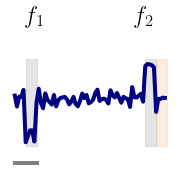

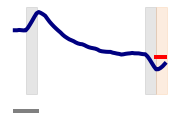

In [7]:
plt.rcParams['text.usetex'] = True

stim2_begin = romo.stim1_end + fixed_delay
stim2_end = stim2_begin + romo.stimulus2_duration_discrete
end_decision = stim2_end + romo.decision_duration_discrete
net.noise_std = noise_std
cmap = plt.get_cmap('jet')
color = cmap(0)
x1, y1, mask1, _, _, _ = romo.generate_data(1, fpairs=[(20, 24)], fraction_validation_trials=0., 
                                            delay_discrete=fixed_delay)
outp1, trajectories = net.forward(x1[:, :end_task, :], return_dynamics=True)
trajectories = trajectories.detach().numpy().squeeze()
rates = np.tanh(trajectories)
time = time_mapping(np.arange(x1.shape[1]))

fig, ax = plt.subplots(figsize=(3, 2))
x1 = x1.squeeze().numpy()
ax.plot(time[:end_task], x1[:end_task], lw=4, c=color)
ax.set_axis_off()
ax.axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), alpha=.2, color='gray', ymin=0.2, ymax=1)
ax.axvspan(time_mapping(stim2_begin), time_mapping(stim2_end), alpha=.2, color='gray', ymin=0.2, ymax=1)
ax.axvspan(time_mapping(stim2_end), time_mapping(end_decision), alpha=.2, color='sandybrown', ymin=0.2, ymax=1)
ax.text(s='$f_1$', x=.09, y=.18, size=24)
ax.text(s='$f_2$', x=1.1, y=.18, size=24)
ax.plot([0, 0.2], [-.15, -.15], c='gray', lw=4)
# plt.savefig('figure_2/romo_input.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3, 2))
y1 = y1.squeeze().numpy()
ax.plot(time_mapping(np.arange(outp1.shape[1])), outp1[0,:,0].detach().numpy(), color=color, zorder=30, lw=4)
ax.plot(time_mapping(np.arange(stim2_end, end_decision)), y1[stim2_end:end_decision], color='r', zorder=20, lw=4)
ax.set_axis_off()
ax.axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), alpha=.2, color='gray', ymin=0.2, ymax=1)
ax.axvspan(time_mapping(stim2_begin), time_mapping(stim2_end), alpha=.2, color='gray', ymin=0.2, ymax=1)
ax.axvspan(time_mapping(stim2_end), time_mapping(end_decision), alpha=.2, color='sandybrown', ymin=0.2, ymax=1)
ax.plot([0, 0.2], [-.5, -.5], c='gray', lw=4)
# plt.savefig('figure_2/romo_output.pdf', bbox_inches='tight')

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Use the colorbar set_ticks() method instead.
/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


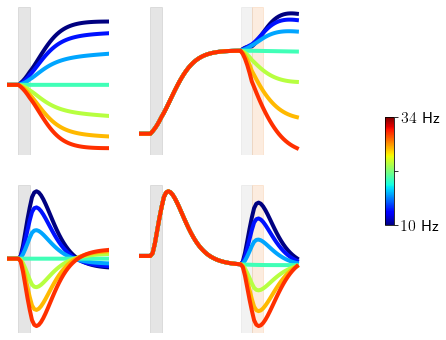

In [8]:
f1s = list(range(10, 35, 4))
f2 = 20
net.noise_std = 0
delay = 700 // 20
time1 = time_mapping(delay + 10)
time2 = time_mapping(end_task + 10)
fig, axes = plt.subplots(2, 2, gridspec_kw={'width_ratios': [time1 / time2, 1]}, figsize=(6, 6))

cmap = plt.get_cmap('jet')
for i, f1 in enumerate(f1s):
    input_c, target_c, mask_c, _, _, _ = romo.generate_data(1, fpairs=[(f1, f2)], std=0., 
                                                           fraction_validation_trials=0.,
                                                           delay_discrete=delay)
    output_c, activations = net.forward(input_c, return_dynamics=True)
    activations = activations.detach().numpy().squeeze()
    rates = np.tanh(activations)
    ## INVERSION HERE
    kappa1 = rates @ m2 / hidden_size
    kappa2 = rates @ m1 / hidden_size
    seq_len = input_c.shape[1] + 1
    axes[0][0].plot(time_mapping(np.arange(len(kappa1))), kappa1, label=str(f1), c=cmap(i/len(f1s)), lw=4)
    axes[1][0].plot(time_mapping(np.arange(len(kappa1))), kappa2, label=str(f1), c=cmap(i/len(f1s)), lw=4)
    
for ax in (axes[0][0], axes[1][0]):
    ax.set(xlim=(0, time1), yticks=[], xticks=[])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), color='gray', alpha=.2)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

f1 = 10
f2s = list(range(10, 35, 4))
for i, f2 in enumerate(f2s):
    input_c, target_c, mask_c, _, _, _ = romo.generate_data(1, fpairs=[(f1, f2)], std=0., 
                                                           fraction_validation_trials=0.,
                                                           delay_discrete=delay)
    output_c, activations = net.forward(input_c, return_dynamics=True)
    activations = activations.detach().numpy().squeeze()
    rates = np.tanh(activations)
    ## INVERSION HERE
    kappa1 = rates @ m2 / hidden_size
    kappa2 = rates @ m1 / hidden_size
    seq_len = input_c.shape[1] + 1
    axes[0][1].plot(time_mapping(np.arange(len(kappa1))), kappa1, label=str(f2), c=cmap(i/len(f2s)), lw=4)
    axes[1][1].plot(time_mapping(np.arange(len(kappa1))), kappa2, label=str(f2), c=cmap(i/len(f2s)), lw=4)

for ax in (axes[0][1], axes[1][1]):
    ax.set(xlim=(0, time2), yticks=[], xticks=[])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(time_mapping(romo.fixation_duration_discrete), time_mapping(romo.stim1_end), color='gray', alpha=.2)
    stim2_beg = romo.stim1_end + delay
    stim2_end = stim2_beg + romo.stimulus2_duration_discrete
    ax.axvspan(time_mapping(stim2_beg), time_mapping(stim2_end), color='silver', alpha=.2)
    ax.axvspan(time_mapping(stim2_end), time_mapping(stim2_end + romo.decision_duration_discrete), 
               color='sandybrown', alpha=.2)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

w = .02
h = .25
ax_cbar = fig.add_axes((1, .5 - h/2, w, h))
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
ax_cbar.set(yticks=[0, 1], yticklabels=['$10$ Hz', '', '$34$ Hz'])

plt.show()
# fig.savefig('figures/3_romo_kappas.pdf', bbox_inches='tight')

[[ True False False False False False]
 [ True  True False False False False]
 [ True  True  True False False False]
 [ True  True  True  True False False]
 [ True  True  True  True  True False]
 [ True  True  True  True  True  True]]
[[ 0.00000000e+00  1.28324371e-01  1.03769373e+00  7.95188980e-02
   3.25628021e-01  3.72144699e-02]
 [ 0.00000000e+00  0.00000000e+00  9.53674316e-09  1.07503613e+00
   3.05990234e-01 -6.47100220e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28614731e-01
   1.10067871e-01 -4.42779053e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -4.93777863e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.57446167e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


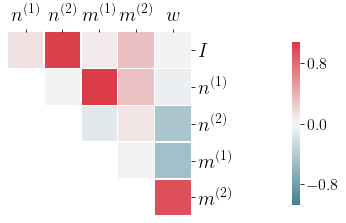

In [9]:
lsize = 20
plt.rcParams['text.usetex'] = True
rescaled_vectors = [-wi, n2, n1, m2, m1, wo / 4]
ov = helpers.overlap_matrix(rescaled_vectors)
labels = ['$I$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$w$']
bound = np.max((np.abs(np.min(ov)), np.abs(np.max(ov))))
fig, ax = plt.subplots(figsize=(6, 6))
helpers.get_lower_tri_heatmap(ov, cbar=True, cbar_shrink=.5, figsize=(4, 3), cbar_pad=.3, ax=ax)
ax.set_xticks(np.array(list(range(len(labels) - 1))) + .5)
ax.set_xticklabels(labels[1:])
ax.set_yticks(np.array(list(range(len(labels) - 1))) + .5)
ax.set_yticklabels(labels[:-1])
ax.xaxis.set_tick_params(labelsize=lsize, rotation=0)
ax.yaxis.set_tick_params(rotation=0, labelsize=lsize)
# plt.savefig('si_networks/romo_overlap.pdf', bbox_inches='tight')

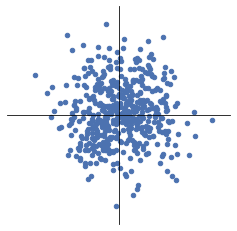

In [10]:
color = sns.color_palette('deep')[0]
clustering.pop_scatter_linreg(m1, n1, np.zeros(hidden_size), colors=(color,), size=20, linreg=False, 
                             figsize=(4, 4))
# plt.savefig('figure_2/romo_scatter1.pdf', bbox_inches='tight')

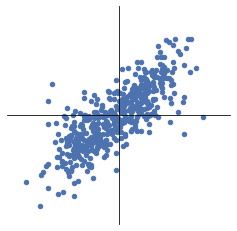

In [11]:
clustering.pop_scatter_linreg(m2, n2, np.zeros(hidden_size), colors=(color,), size=20, linreg=False,
                             figsize=(4, 4))
# plt.savefig('figure_2/romo_scatter2.pdf', bbox_inches='tight')

In [12]:
net2 = clustering.to_support_net(net, np.zeros(hidden_size))
loss, acc = romo.test_romo(net2, x_val, y_val, mask_val)
print(loss, acc)

0.022781258448958397 1.0


<AxesSubplot:xlabel='$f_1$'>

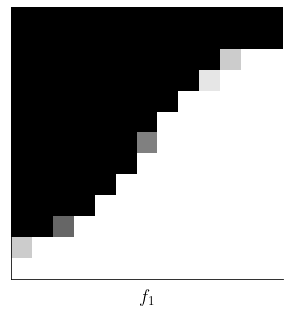

In [13]:
romo.psychometric_matrices(net, binarize=1)

<AxesSubplot:xlabel='$f_1$'>

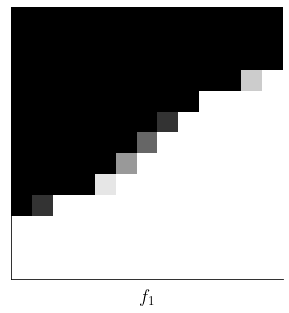

In [14]:
romo.psychometric_matrices(net2, binarize=1)